In [253]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
!pip install sklearn-pandas
!pip install torch
!pip install torchtuples
!pip install pycox

In [254]:
import numpy as np
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

import pandas as pd
from pycox.models import PCHazard
from pycox.evaluation import EvalSurv

In [255]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [256]:
df = pd.read_csv("data/Recurrence free survival in breast cancer patients.csv")
df_test = df.sample(frac=0.2, random_state=42)  # Split 20% for test
df_train = df.drop(df_test.index)
df_val = df_train.sample(frac=0.2, random_state=42)  # Split 20% for validation
df_train = df_train.drop(df_val.index)

durations_train = df_train['time'].values  # 'time' is the hospital stay length
events_train = df_train['status'].values  # 'status' is the event indicator (1 = event, 0 = censored)
durations_val = df_val['time'].values
events_val = df_val['status'].values
durations_test = df_test['time'].values
events_test = df_test['status'].values

In [257]:
df_train.head()

,id,treat,age,men,size,grade,nodes,prog,oest,time,status
1,2,1,56,2,12,2,7,61,77,2018,1
4,5,0,73,2,35,2,1,26,65,772,1
5,6,0,32,1,57,3,24,0,13,448,1
7,8,0,65,2,16,2,1,192,25,2161,0
9,10,0,66,2,18,2,7,0,3,2014,0


In [258]:
cols_standardize = ['age', 'size', 'nodes', 'prog', 'oest']  
cols_leave = ['treat', 'men', 'grade']  

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [259]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [260]:
num_durations = 10
labtrans = PCHazard.label_transform(num_durations)
get_target = lambda df: (df['time'].values, df['status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [261]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransPCHazard

Note that `y_train` now consist of three labels: the interval index, the event indicator, and the proportion of the interval before the event/censoring occur (i.e, $\rho(t_i)$ in the [paper](https://arxiv.org/abs/1910.06724)).

In [262]:
y_train

(array([7, 2, 1, 8, 7, 0, 5, 2, 6, 6, 3, 6, 6, 6, 4, 4, 5, 5, 5, 5, 4, 5,
        4, 4, 1, 3, 9, 8, 1, 6, 5, 6, 5, 0, 6, 6, 6, 6, 1, 6, 1, 0, 0, 6,
        1, 3, 2, 0, 1, 4, 3, 3, 1, 2, 7, 9, 3, 1, 7, 5, 2, 2, 3, 2, 5, 5,
        6, 3, 1, 2, 6, 8, 7, 6, 7, 4, 1, 3, 6, 5, 0, 4, 1, 3, 2, 4, 2, 1,
        1, 5, 5, 7, 2, 1, 5, 6, 3, 2, 2, 4, 0, 7, 1, 8, 9, 7, 7, 3, 8, 0,
        6, 6, 4, 4, 2, 8, 7, 1, 3, 2, 0, 7, 0, 4, 2, 1, 2, 8, 6, 6, 1, 3,
        5, 2, 3, 2, 2, 3, 8, 7, 3, 3, 4, 6, 4, 4, 3, 2, 4, 1, 0, 6, 6, 7,
        1, 3, 5, 2, 8, 9, 3, 6, 8, 6, 6, 3, 2, 6, 6, 6, 7, 7, 0, 6, 4, 6,
        5, 2, 5, 4, 3, 0, 4, 2, 3, 0, 3, 2, 2, 3, 4, 4, 2, 2, 1, 7, 0, 4,
        3, 6, 2, 1, 6, 4, 1, 3, 6, 2, 2, 5, 1, 5, 2, 9, 6, 1, 6, 5, 1, 5,
        9, 8, 2, 2, 7, 7, 8, 2, 1, 7, 7, 2, 8, 6, 3, 4, 3, 1, 8, 2, 3, 6,
        2, 3, 2, 5, 5, 6, 7, 7, 3, 4, 7, 4, 5, 6, 5, 4, 5, 1, 0, 2, 4, 2,
        3, 3, 3, 8, 6, 1, 8, 8, 8, 0, 3, 2, 2, 2, 2, 5, 1, 6, 6, 5, 2, 2,
        0, 8, 3, 7, 3, 8, 3, 2, 8, 2, 

In [263]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [264]:
# net = torch.nn.Sequential(
#     torch.nn.Linear(in_features, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, 32),
#     torch.nn.ReLU(),
#     torch.nn.BatchNorm1d(32),
#     torch.nn.Dropout(0.1),
    
#     torch.nn.Linear(32, out_features)
# )

In [265]:
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

/opt/miniconda3/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


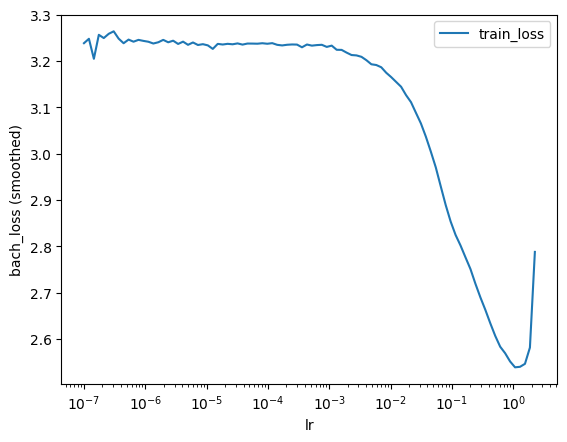

In [266]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=8)
_ = lr_finder.plot()

In [267]:
lr_finder.get_best_lr()

0.10722672220103299

Often, this learning rate is a little high, so we instead set it manually to 0.01

In [268]:
model.optimizer.set_lr(0.016)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [269]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.1482,	val_loss: 3.4316
1:	[0s / 0s],		train_loss: 2.9214,	val_loss: 3.4501
2:	[0s / 0s],		train_loss: 2.6689,	val_loss: 3.3166
3:	[0s / 0s],		train_loss: 2.5315,	val_loss: 3.1275
4:	[0s / 0s],		train_loss: 2.2711,	val_loss: 2.9160
5:	[0s / 0s],		train_loss: 2.0777,	val_loss: 2.6156
6:	[0s / 0s],		train_loss: 1.9018,	val_loss: 2.3133
7:	[0s / 0s],		train_loss: 1.6710,	val_loss: 2.0514
8:	[0s / 0s],		train_loss: 1.5085,	val_loss: 1.8338
9:	[0s / 0s],		train_loss: 1.3948,	val_loss: 1.6974
10:	[0s / 0s],		train_loss: 1.2560,	val_loss: 1.6070
11:	[0s / 0s],		train_loss: 1.2639,	val_loss: 1.5561
12:	[0s / 0s],		train_loss: 1.2433,	val_loss: 1.5313
13:	[0s / 0s],		train_loss: 1.2070,	val_loss: 1.5204
14:	[0s / 0s],		train_loss: 1.1869,	val_loss: 1.5213
15:	[0s / 0s],		train_loss: 1.1950,	val_loss: 1.5224
16:	[0s / 0s],		train_loss: 1.1871,	val_loss: 1.5240
17:	[0s / 0s],		train_loss: 1.1575,	val_loss: 1.5211
18:	[0s / 0s],		train_loss: 1.1322,	val_loss: 1.5126
19:

/opt/miniconda3/lib/python3.9/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


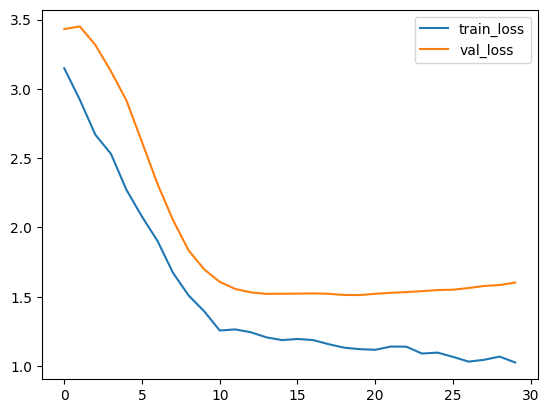

In [270]:
_ = log.plot()

In [271]:
surv = model.predict_surv_df(x_test)

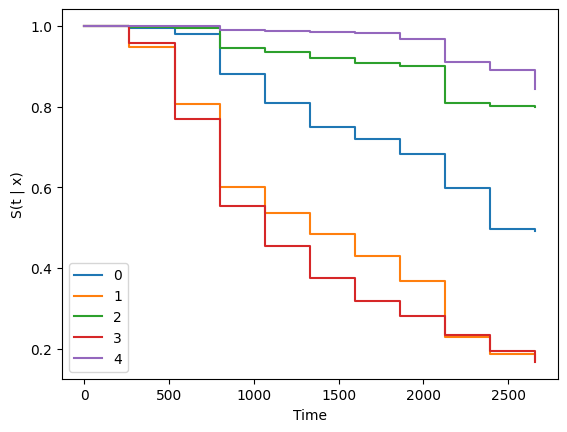

In [272]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [273]:
model.sub = 10

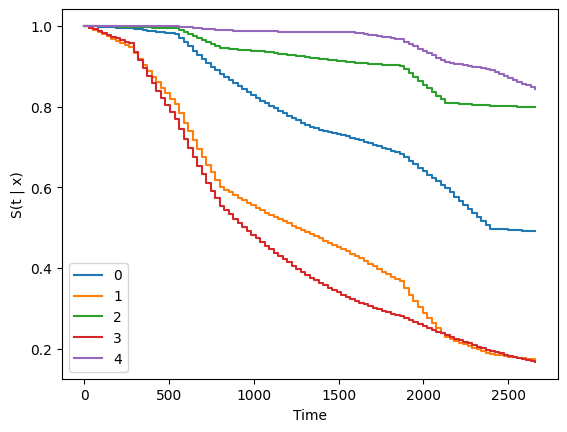

In [274]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction.
We set `censor_surv = 'km'` to state that we want to use Kaplan-Meier for estimating the censoring distribution.


In [275]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

#### Concordance

We start with the event-time concordance by [Antolini et al. 2005](https://onlinelibrary.wiley.com/doi/10.1002/sim.2427).

In [276]:
ev.concordance_td('antolini')

0.65880446525027

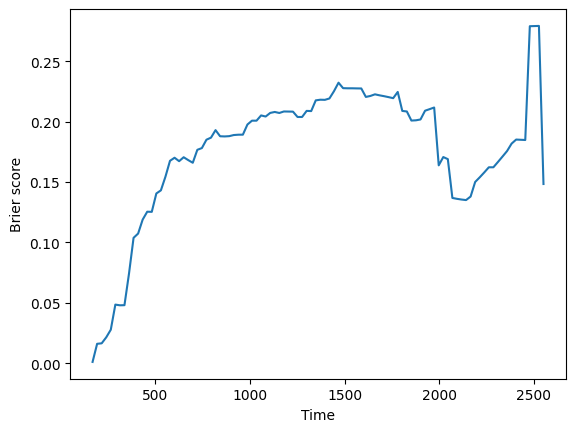

In [277]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

#### Negative binomial log-likelihood

In a similar manner, we can plot the the [IPCW negative binomial log-likelihood](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5).

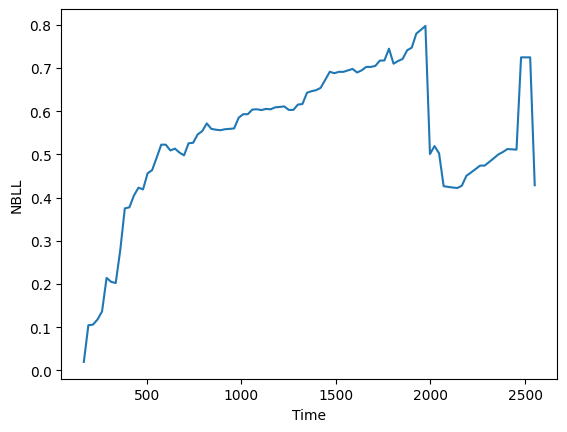

In [278]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

#### Integrated scores

The two time-dependent scores above can be integrated over time to produce a single score [Graf et al. 1999](https://onlinelibrary.wiley.com/doi/abs/10.1002/%28SICI%291097-0258%2819990915/30%2918%3A17/18%3C2529%3A%3AAID-SIM274%3E3.0.CO%3B2-5). In practice this is done by numerical integration over a defined `time_grid`.

In [279]:
ev.integrated_brier_score(time_grid) 

0.17676263979306742

In [280]:
ev.integrated_nbll(time_grid) 

0.5458456674959362